In [1]:
import pandas as pd
import numpy as np
import torch
import os
import random 
#import seaborn as sns
import matplotlib.pyplot as plt

# PREPROCESSING DURANTE L'IMPORTAZIONE

In [3]:
cartella = '01-12/' 
dataset = pd.DataFrame()
for file_name in os.listdir(cartella):
    if file_name.endswith('.csv'):
        print("importazione:", file_name)
        file_path = os.path.join(cartella, file_name)   
        df_sampled = pd.read_csv(file_path)        
        dataset = pd.concat([dataset, df_sampled])

'cartella = \'01-12/\' \ndataset = pd.DataFrame()\nfor file_name in os.listdir(cartella):\n    if file_name.endswith(\'.csv\'):\n        print("importazione:", file_name)\n        file_path = os.path.join(cartella, file_name)   \n        df_sampled = pd.read_csv(file_path)        \n        dataset = pd.concat([dataset, df_sampled])'

In [3]:
columns_to_drop = dataset.select_dtypes(include=['object']).columns
columns_to_drop = columns_to_drop[columns_to_drop != ' Label']  # Esclude 'label'
dataset.drop(columns=columns_to_drop, inplace=True)
dataset = dataset.replace([np.inf, -np.inf], np.nan)
dataset = dataset.dropna()
dataset = dataset.loc[:, dataset.nunique() > 1]

In [5]:
dataset.columns

Index(['Unnamed: 0', ' Source Port', ' Destination Port', ' Protocol',
       ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets',
       'Total Length of Fwd Packets', ' Total Length of Bwd Packets',
       ' Fwd Packet Length Max', ' Fwd Packet Length Min',
       ' Fwd Packet Length Mean', ' Fwd Packet Length Std',
       'Bwd Packet Length Max', ' Bwd Packet Length Min',
       ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s',
       ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max',
       ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std',
       ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean',
       ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags',
       ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
       ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length',
       ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance',
       ' SYN Flag C

In [4]:
# Mantieni tutte le colonne eccetto le prime 4
dataset = dataset.iloc[:, 4:]

# CALCOLARE LA CORRELAZIONE

In [7]:
dataset[" Label"].value_counts()

 Label
DrDoS_SNMP       5149261
DrDoS_DNS        4908665
DrDoS_MSSQL      4396046
DrDoS_NetBIOS    3963446
DrDoS_UDP        3094002
DrDoS_SSDP       2568569
TFTP             2323125
DrDoS_LDAP       2141300
Syn              1379983
DrDoS_NTP        1195690
BENIGN             29343
Name: count, dtype: int64

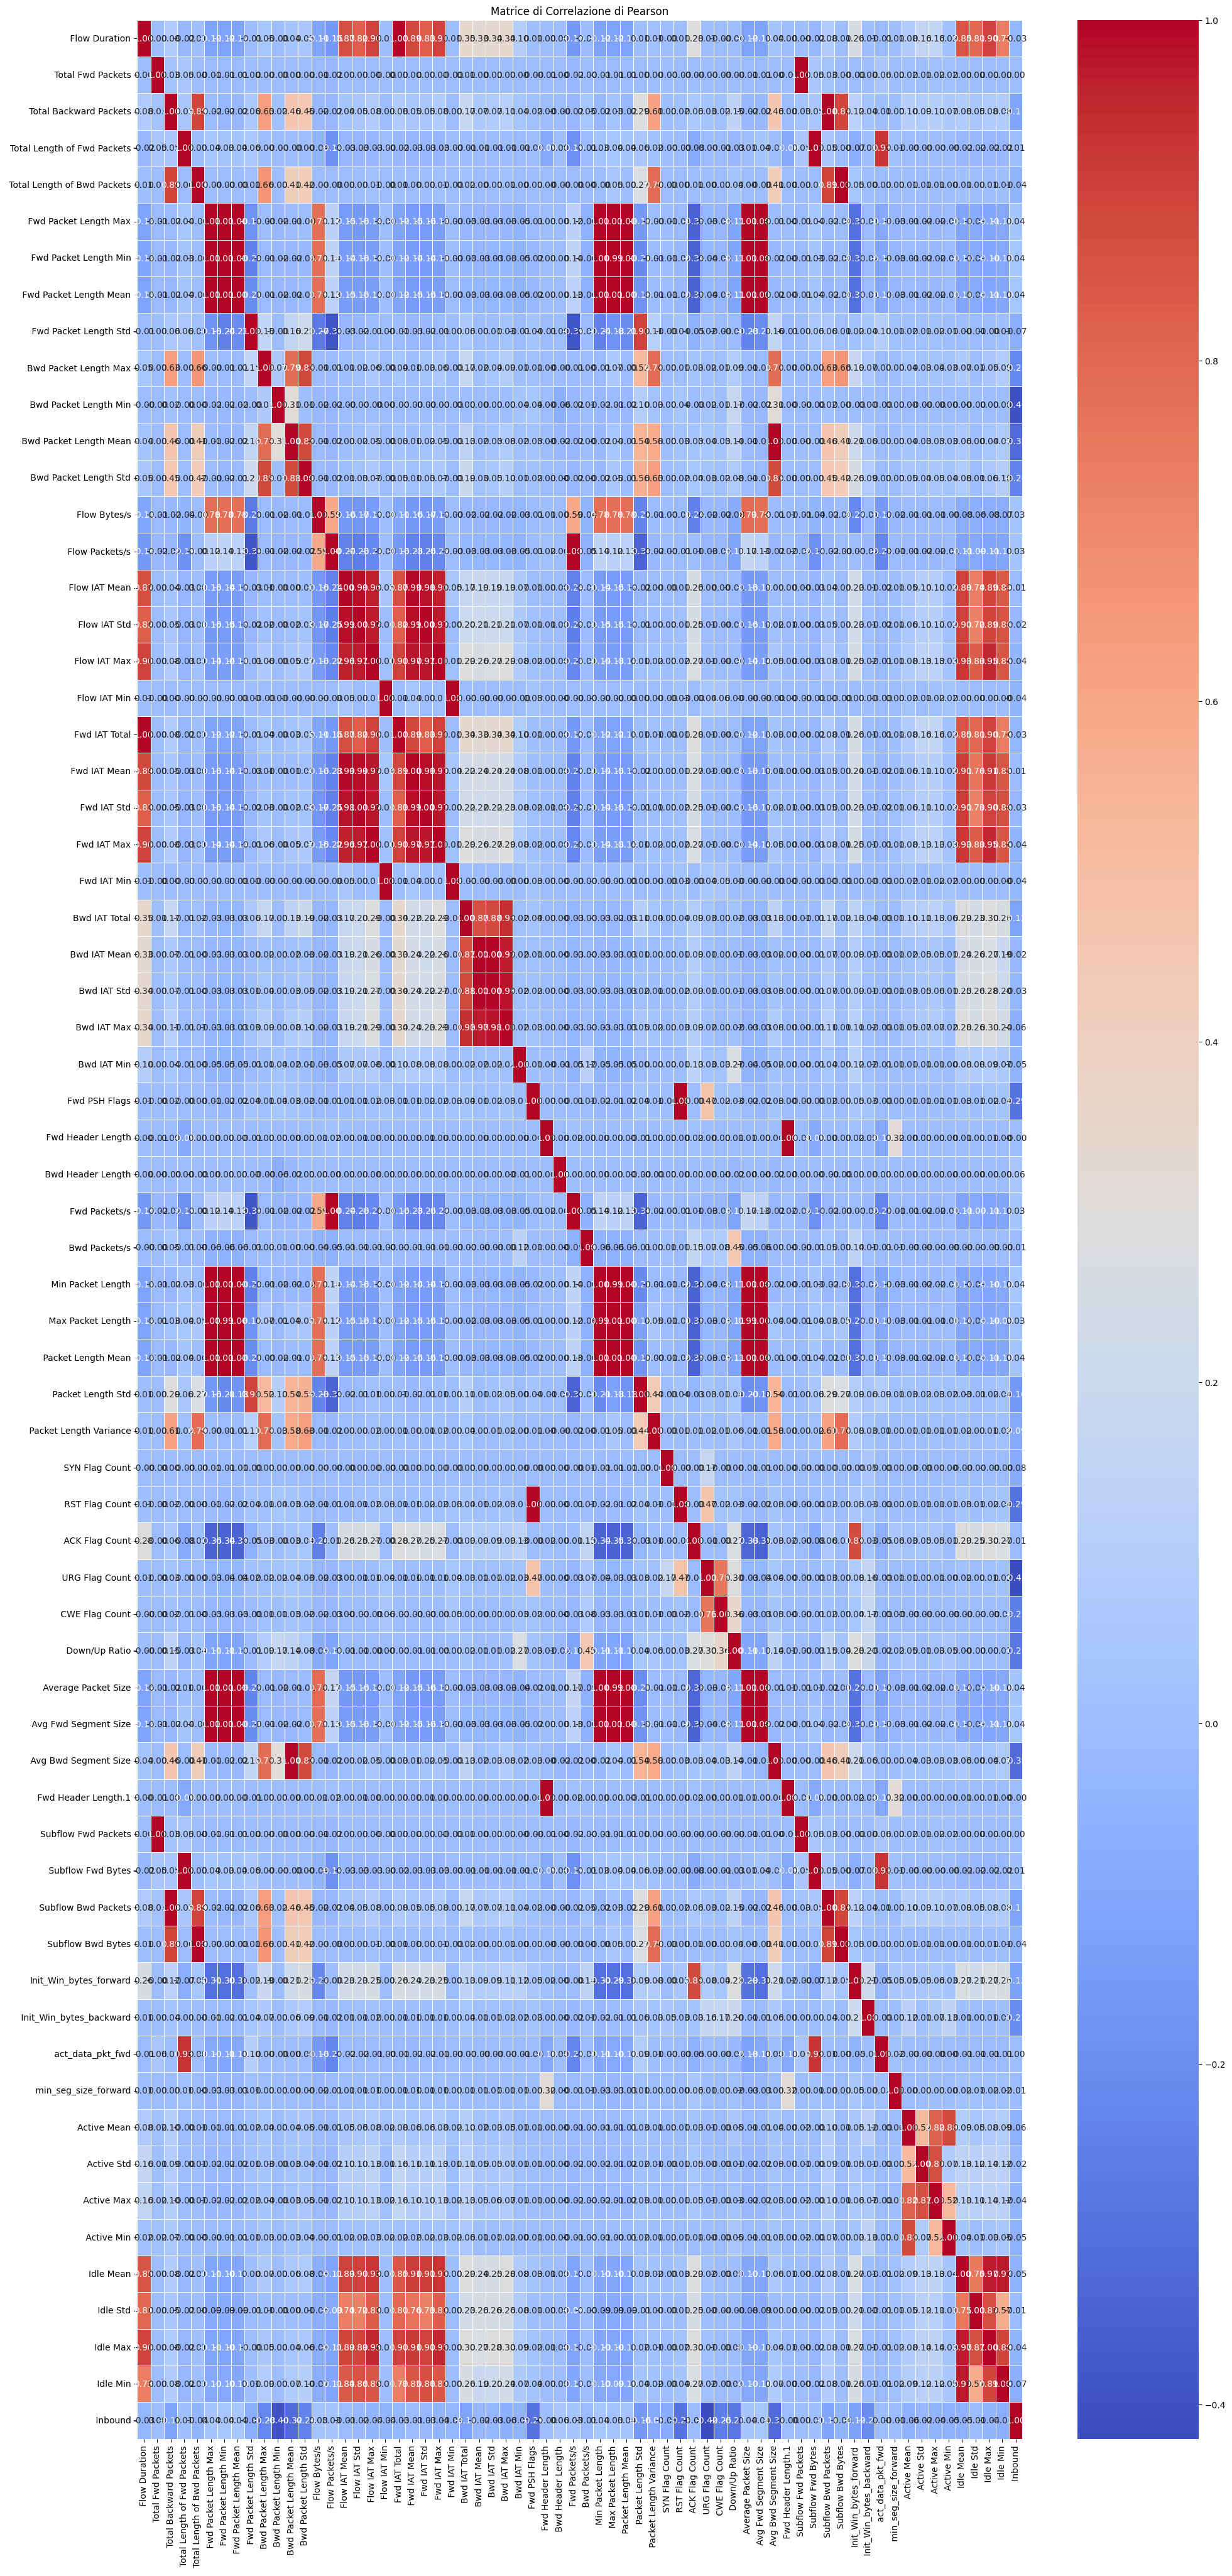

In [5]:
dataframe_predictor=dataset.drop(columns=[' Label'])
pearson_corr = dataframe_predictor.corr(method='pearson')

# Imposta la dimensione della figura
plt.figure(figsize=(50, 50))

plt.subplot(1, 2, 1)  
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Matrice di Correlazione di Pearson')

plt.show()

In [6]:
print("Coppie di variabili con correlazione di Pearson > 0.9:")
pearson_high_corr = [(col1, col2, pearson_corr.loc[col1, col2]) 
                     for col1 in pearson_corr.columns for col2 in pearson_corr.columns 
                     if col1 != col2 and pearson_corr.loc[col1, col2] > 0.9]
#for col1, col2, coeff in pearson_high_corr:
    #print(f"{col1} e {col2}: {coeff:.2f}")
print(len(pearson_high_corr))

Coppie di variabili con correlazione di Pearson > 0.9:
138


In [7]:
def correlation(dataset, soglia):
    col_corr = set()  # Set of all the names of correlated columns
    
    corr_matrix = dataset.corr()
    
    for i in range(len(corr_matrix.columns)):    
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > soglia: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
                
    return col_corr

In [8]:
df_correlazione = dataframe_predictor.corr()
df_correlazione = df_correlazione.abs().unstack() # absolute value of corr coef
df_correlazione = df_correlazione.sort_values(ascending=False)
df_correlazione = df_correlazione[df_correlazione > 0.9]
df_correlazione = df_correlazione[df_correlazione < 1]
df_correlazione = pd.DataFrame(df_correlazione).reset_index()
df_correlazione.columns = ['attributo1', 'attributo2', 'coefficiente']
df_correlazione.shape

(122, 3)

In [86]:
df_correlazione

,attributo1,attributo2,coefficiente
0,Bwd Packet Length Mean,Avg Bwd Segment Size,1.000000
1,Avg Bwd Segment Size,Bwd Packet Length Mean,1.000000
2,Fwd Packets/s,Flow Packets/s,0.999635
3,Flow Packets/s,Fwd Packets/s,0.999635
4,Fwd Packet Length Min,Min Packet Length,0.999381
...,...,...,...
99,Bwd IAT Std,Bwd IAT Max,0.907528
100,Packet Length Std,Avg Bwd Segment Size,0.901298
101,Avg Bwd Segment Size,Packet Length Std,0.901298
102,Bwd Packet Length Mean,Packet Length Std,0.901298


In [9]:
# find groups of correlated features

grouped_feature_ls = []
correlated_groups = []

for feature in df_correlazione["attributo1"].unique():
    
    if feature not in grouped_feature_ls:

        # find all features correlated to a single feature
        correlated_block = df_correlazione[df_correlazione["attributo1"] == feature]
        grouped_feature_ls = grouped_feature_ls + list(correlated_block["attributo2"].unique()) + [feature]

        # append the block of features to the list
        correlated_groups.append(correlated_block)
i=0
for group in correlated_groups:
    i=i+1
    print("gruppo numero:", i)
    print(group)
    print()
print(len(correlated_groups))

gruppo numero: 1
        attributo1     attributo2  coefficiente
0   Flow Packets/s  Fwd Packets/s      0.999989

gruppo numero: 2
            attributo1               attributo2  coefficiente
2    Min Packet Length    Fwd Packet Length Min      0.999986
23   Min Packet Length   Fwd Packet Length Mean      0.998812
24   Min Packet Length     Avg Fwd Segment Size      0.998812
29   Min Packet Length       Packet Length Mean      0.998775
32   Min Packet Length      Average Packet Size      0.998071
44   Min Packet Length    Fwd Packet Length Max      0.997790
62   Min Packet Length        Max Packet Length      0.994958

gruppo numero: 3
      attributo1      attributo2  coefficiente
8  Fwd IAT Total   Flow Duration      0.999933

gruppo numero: 4
        attributo1      attributo2  coefficiente
10    Flow IAT Max     Fwd IAT Max      0.999647
80    Flow IAT Max    Fwd IAT Mean      0.974653
85    Flow IAT Max     Fwd IAT Std      0.973645
88    Flow IAT Max    Flow IAT Std      0.96948

In [10]:
group_head = []
for group in correlated_groups:
    group_head.append(group.iloc[0,0])

In [11]:
features_to_remove = [feature for feature in grouped_feature_ls if feature not in group_head]
len(features_to_remove)

23

In [15]:
features_to_remove

[' Min Packet Length',
 ' Avg Fwd Segment Size',
 ' Fwd Packet Length Mean',
 ' Packet Length Mean',
 ' Average Packet Size',
 ' Fwd Packet Length Max',
 ' Max Packet Length',
 ' Flow Packets/s',
 ' Flow Duration',
 ' Idle Max',
 ' Fwd IAT Max',
 ' Flow IAT Max',
 ' Fwd IAT Mean',
 ' Flow IAT Std',
 ' Fwd IAT Mean',
 ' Flow IAT Mean',
 ' Fwd IAT Max',
 ' Flow IAT Max',
 ' Fwd IAT Min',
 ' Bwd IAT Std',
 ' Bwd IAT Max',
 ' Idle Max',
 ' Idle Min',
 ' Fwd IAT Max',
 ' Flow IAT Max',
 ' Bwd IAT Max',
 ' act_data_pkt_fwd',
 ' act_data_pkt_fwd',
 ' Idle Max',
 ' Fwd Packet Length Std']

In [12]:
df_no_correlation = dataset.drop(columns=features_to_remove)

In [108]:
df_no_correlation.shape

(154293, 46)

In [13]:
df_no_correlation.to_csv("dataset_no_correlazioni.csv")

# PROVE 24 -01

| **Colonna**              | **Significato**                                                                                  |
|--------------------------|--------------------------------------------------------------------------------------------------|
| **Source IP**            | Indirizzo IP sorgente del flusso.                                                               |
| **Destination IP**       | Indirizzo IP di destinazione del flusso.                                                        |
| **Source Port**          | Porta sorgente utilizzata per il traffico.                                                      |
| **Destination Port**     | Porta di destinazione.                                                                          |
| **Protocol**             | Protocollo utilizzato (es. TCP, UDP, ICMP).                                                     |
| **Flow Duration**        | Durata totale del flusso in microsecondi.                                                       |
| **Total Fwd Packets**    | Numero totale di pacchetti inviati dal mittente (forward direction).                            |
| **Total Bwd Packets**    | Numero totale di pacchetti ricevuti dal mittente (backward direction).                          |
| **Total Length of Fwd Packets** | Dimensione totale (in byte) dei pacchetti inviati dal mittente.                          |
| **Total Length of Bwd Packets** | Dimensione totale (in byte) dei pacchetti ricevuti dal mittente.                        |
| **Fwd Packet Length Mean** | Lunghezza media dei pacchetti inviati in avanti (forward).                                     |
| **Bwd Packet Length Mean** | Lunghezza media dei pacchetti inviati indietro (backward).                                    |
| **Flow Bytes/s**         | Velocità di trasmissione dei byte per secondo.                                                  |
| **Flow Packets/s**       | Velocità di trasmissione dei pacchetti per secondo.                                             |
| **Fwd IAT Mean**         | Tempo medio tra pacchetti successivi inviati in avanti (Forward Inter-Arrival Time).            |
| **Bwd IAT Mean**         | Tempo medio tra pacchetti successivi inviati indietro.                                          |
| **Active Mean**          | Tempo medio in cui il flusso è attivo.                                                          |
| **Idle Mean**            | Tempo medio in cui il flusso è inattivo.                                                        |
| **Packet Length Mean**   | Lunghezza media di tutti i pacchetti.                                                           |
| **PSH Flags**            | Numero di pacchetti con il flag PSH (Push).                                                     |
| **ACK Flags**            | Numero di pacchetti con il flag ACK (Acknowledgment).                                           |
| **SYN Flag Count**       | Numero di pacchetti con il flag SYN (Synchronize).                                              |
| **Flow ID**              | Identificativo univoco del flusso.                                                              |


In [11]:
cartella = '03-11/' 
dataset = pd.DataFrame()
for file_name in os.listdir(cartella):
    if file_name.endswith('.csv'):
        print("importazione:", file_name)
        file_path = os.path.join(cartella, file_name)   
        df_sampled = pd.read_csv(file_path)        
        dataset = pd.concat([dataset, df_sampled])

importazione: UDP.csv


/tmp/ipykernel_803476/569529085.py:7: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sampled = pd.read_csv(file_path)


importazione: MSSQL.csv


/tmp/ipykernel_803476/569529085.py:7: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sampled = pd.read_csv(file_path)


importazione: UDPLag.csv


/tmp/ipykernel_803476/569529085.py:7: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sampled = pd.read_csv(file_path)


importazione: Syn.csv


/tmp/ipykernel_803476/569529085.py:7: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sampled = pd.read_csv(file_path)


importazione: LDAP.csv


/tmp/ipykernel_803476/569529085.py:7: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sampled = pd.read_csv(file_path)


importazione: NetBIOS.csv


/tmp/ipykernel_803476/569529085.py:7: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sampled = pd.read_csv(file_path)


importazione: Portmap.csv


/tmp/ipykernel_803476/569529085.py:7: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sampled = pd.read_csv(file_path)


In [12]:
dataset.columns

Index(['Unnamed: 0', 'Flow ID', ' Source IP', ' Source Port',
       ' Destination IP', ' Destination Port', ' Protocol', ' Timestamp',
       ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets',
       'Total Length of Fwd Packets', ' Total Length of Bwd Packets',
       ' Fwd Packet Length Max', ' Fwd Packet Length Min',
       ' Fwd Packet Length Mean', ' Fwd Packet Length Std',
       'Bwd Packet Length Max', ' Bwd Packet Length Min',
       ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s',
       ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max',
       ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std',
       ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean',
       ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags',
       ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags',
       ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
       ' Bwd Packets/s', ' Min Packet Len

In [13]:
label_mittente_destinatario=dataset[[" Source IP", " Destination IP", " Label"]]
label_mittente_destinatario.to_csv("label_mittente_destinatario_03_11.csv", index=False)

In [14]:
nuovo_dataset = label_mittente_destinatario.groupby([" Source IP", " Destination IP"])[" Label"].unique().reset_index()
nuovo_dataset.rename(columns={" Label": "lista label"}, inplace=True)
nuovo_dataset[nuovo_dataset["lista label"].apply(len) > 1]

,Source IP,Destination IP,lista label
243,172.16.0.5,192.168.50.4,"[MSSQL, UDP, LDAP, UDPLag, Syn, NetBIOS, Portmap]"
632,192.168.50.4,172.16.0.5,"[MSSQL, UDP, LDAP, UDPLag, Syn, NetBIOS, Portmap]"


In [15]:
nuovo_dataset_senza_multiple_labels = nuovo_dataset[nuovo_dataset["lista label"].apply(len) == 1]
nuovo_dataset_senza_multiple_labels["Label"] = nuovo_dataset_senza_multiple_labels["lista label"].apply(lambda x: x[0])
nuovo_dataset_senza_multiple_labels.drop(columns=["lista label"], inplace=True)
nuovo_dataset_senza_multiple_labels.to_csv("label_mittente_destinatario_03_11.csv", index=False)

/tmp/ipykernel_803476/1296749966.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nuovo_dataset_senza_multiple_labels["Label"] = nuovo_dataset_senza_multiple_labels["lista label"].apply(lambda x: x[0])
/tmp/ipykernel_803476/1296749966.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nuovo_dataset_senza_multiple_labels.drop(columns=["lista label"], inplace=True)


In [2]:
import pandas as pd
import numpy as np
import torch
import os
import random 
#import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
dataset_01_02=pd.read_csv("label_mittente_destinatario_01_12.csv")

In [13]:
lista_dispositivi_01_12 = pd.concat([dataset_01_02[' Source IP'], dataset_01_02[' Destination IP']]).unique().tolist()

In [14]:
len(lista_dispositivi_01_12)

494

In [5]:
dataset_03_11=pd.read_csv("label_mittente_destinatario_03_11.csv")

In [15]:
lista_dispositivi_03_11 = pd.concat([dataset_03_11[' Source IP'], dataset_03_11[' Destination IP']]).unique().tolist()

In [16]:
len(lista_dispositivi_03_11)

1289

In [50]:
df=pd.read_csv("01-12/UDPLag.csv")

/tmp/ipykernel_869582/2923383320.py:1: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("01-12/UDPLag.csv")


In [51]:
df[" Total Backward Packets"].sum()

np.int64(122796)

In [52]:
df[" Total Fwd Packets"].sum()

np.int64(1099516)